In [13]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.model_selection import KFold
import matplotlib.ticker as ticker
import TsModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [ ]:
"""
This tests the fitlered solar plant 1 data,
all spikes with daily diff > 6000 are removed.

TS and TS-C are carried out on the opt #c

Clustering results are listed along with the GP results
"""

In [26]:
exp22_2_results = {
    'nn_train_accuracy' : nn_train_accuracy,
    'nn_test_accuracy':nn_test_accuracy,
    'nn_r2s':nn_r2s,
    'nn_time':nn_time,
    'gp_train_accuracy':gp_train_accuracy,
    'gp_test_accuracy':gp_test_accuracy,
    'gp_r2s':gp_r2s,
    'gp_time':gp_time,
    'tsl_opt_train_accuracy' : tsl_opt_train_accuracy,
    'tsl_opt_test_accuracy' :tsl_opt_test_accuracy,
    'tsl_r2s':tsl_r2s,
    'tsl_time': tsl_time,
    'tsc_opt_train_accuracy':tsc_opt_train_accuracy,
    'tsc_opt_test_accuracy':tsc_opt_test_accuracy,
    'tsc_r2s':tsc_r2s,
    'tsc_time':tsc_time,
    'gp_tsl_train_accuracy':gp_tsl_train_accuracy,
    'gp_tsl_test_accuracy':gp_tsl_test_accuracy,
    'tsl_train_accuracy':tsl_train_accuracy,
    'tsl_test_accuracy':tsl_test_accuracy,
    'gp_tsl_r2s':gp_tsl_r2s,
    'gp_tsl_time':gp_tsl_time,
    'gp_tsc_train_accuracy':gp_tsc_train_accuracy,
    'gp_tsc_test_accuracy':gp_tsc_test_accuracy,
    'tsc_train_accuracy':tsc_train_accuracy,
    'tsc_test_accuracy':tsc_test_accuracy,
    'gp_tsc_r2s':gp_tsc_r2s,
    'gp_tsc_time':gp_tsc_time,
    'gp_nn_tsl_train_accuracy':gp_nn_tsl_train_accuracy,
    'gp_nn_tsl_test_accuracy':gp_nn_tsl_test_accuracy,
    'gp_nn_tsl_r2s':gp_nn_tsl_r2s,
    'nn_tsl_r2s':nn_tsl_r2s,
    'gp_nn_tsl_time':gp_nn_tsl_time
}

In [27]:
#%store exp22_2_results 

Stored 'exp22_2_results' (dict)


In [2]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/solar_x_train.csv')
x_test = pd.read_csv('Data/FES/solar_x_test.csv')
y_train = pd.read_csv('Data/FES/solar_y_train.csv')
y_test = pd.read_csv('Data/FES/solar_y_test.csv')

In [3]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [4]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [5]:
nn_train_accuracy = []
nn_test_accuracy = []
nn_r2s = []
nn_time = []

def do_nn_exp():
    for fold in range(number_of_folds):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.1),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()]
        )

        start_time = time.time()
        history = neural_network_model.fit(
            x_train, 
            y_train,
            epochs=500, 
            shuffle=True
        )
        time_used = time.time() - start_time

        _, train_rmse = neural_network_model.evaluate(x_train, y_train)
        nn_train_accuracy.append(train_rmse)
        _, test_rmse = neural_network_model.evaluate(x_test, y_test)
        nn_test_accuracy.append(test_rmse)
        nn_r2 = r2_score(y_test, neural_network_model.predict(x_test))
        nn_r2s.append(nn_r2)
        nn_time.append(time_used)
    
    return neural_network_model

In [7]:
nn_model = do_nn_exp()

Epoch 1/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5548976.5000 - root_mean_squared_error: 2352.6006
Epoch 2/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5875240.5000 - root_mean_squared_error: 2421.7676
Epoch 3/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5098741.5000 - root_mean_squared_error: 2257.3660
Epoch 4/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5056935.0000 - root_mean_squared_error: 2248.3442
Epoch 5/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4996530.5000 - root_mean_squared_error: 2233.9751
Epoch 6/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4716776.5000 - root_mean_squared_error: 2170.3191
Epoch 7/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4713203.5000 - root_mean_squared_error: 2169.4028
Epoch 8/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4492111.0000 - root_mean_squared_error: 2118.9775
Epoch 9/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4270928.0000 - root_mean_squared_error: 2064.8909
Epoch 10/500
57/57 

In [15]:
nn_train_accuracy_mean = np.round(np.mean(nn_train_accuracy), 3)
nn_train_accuracy_std = np.round(np.std(nn_train_accuracy), 3)
nn_test_accuracy_mean = np.round(np.mean(nn_test_accuracy), 3)
nn_test_accuracy_std = np.round(np.std(nn_test_accuracy),3)
nn_r2_mean = np.round(np.mean(nn_r2s),3)
nn_r2_std = np.round(np.std(nn_r2s),3)
nn_time_mean = np.round(np.mean(nn_time),3)
nn_time_std = np.round(np.std(nn_time),3)

print(f"NN Train RMSE: {nn_train_accuracy_mean} ± {nn_train_accuracy_std}")
print(f"NN Test RMSE: {nn_test_accuracy_mean} ± {nn_test_accuracy_std}")
print(f"NN R2: {nn_r2_mean} ± {nn_r2_std}")
print(f"NN Time: {nn_time_mean} ± {nn_time_std}")

NN Train RMSE: 405.369 ± 31.3
NN Test RMSE: 390.133 ± 38.648
NN R2: 0.956 ± 0.009
NN Time: 110.543 ± 4.283


In [9]:
nn_model.save('solar_nn_filtered.keras')

In [10]:
def get_tsl_model(x_train, y_train, number_of_rules):
    tsl_model = TsModel.TsModel(number_of_rules, fuzzification_coefficient=1.2)
    tsl_model.fit(x_train, y_train)
    return tsl_model

def get_tsc_model(x_train, y_train, number_of_rules):
    tsc_model = TsModel_constant.TsModel_constant(number_of_rules, fuzzification_coefficient=1.2)
    tsc_model.fit(x_train, y_train)
    return tsc_model

# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

number_of_rules_array = [2,3,4,5,8,10,15,20,25]

FCM training RMSE: 271.1547395480005
FCM training RMSE: 296.45935189320204
FCM training RMSE: 304.37373296169136
FCM training RMSE: 302.421924136678
FCM training RMSE: 301.8955340809999
FCM training RMSE: 294.7294275977527
FCM training RMSE: 303.3554654260684
FCM training RMSE: 301.2178750064183
FCM training RMSE: 301.5525008892028
FCM training RMSE: 295.48899062606193
FCM training RMSE: 266.8246965677802
FCM training RMSE: 291.1493653714652
FCM training RMSE: 299.2006417231885
FCM training RMSE: 297.5922525648997
FCM training RMSE: 296.6155147294858
FCM training RMSE: 293.3318125148407
FCM training RMSE: 298.47297186762853
FCM training RMSE: 296.038451679918
FCM training RMSE: 296.82357139126066
FCM training RMSE: 293.75769314093634
FCM training RMSE: 257.0368139141439
FCM training RMSE: 293.04254844261146
FCM training RMSE: 299.16135623819616
FCM training RMSE: 298.7229721429518
FCM training RMSE: 296.4795760913839
FCM training RMSE: 280.47571126080277
FCM training RMSE: 298.81572284

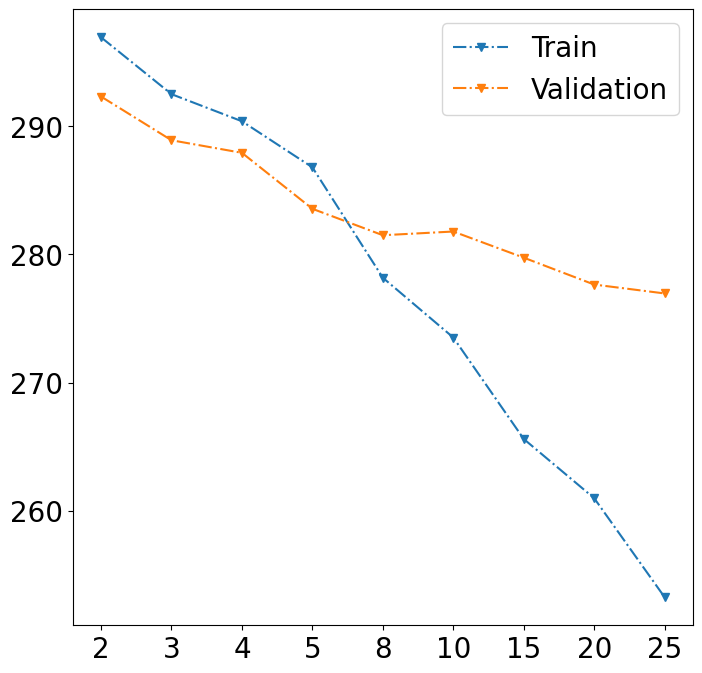

In [ ]:
# Use validation to get the optimal number of rules
tsl_cv_train_accuracy = []
tsl_cv_val_accuracy = []

kf = KFold(n_splits=number_of_folds)

for number_of_rules in number_of_rules_array:
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        ts_model = TsModel.TsModel(number_of_rules, fuzzification_coefficient=1.2)
        
        start_time = time.time()
        ts_model.fit(x_train[train_index], y_train[train_index])
        time_used = time.time() - start_time

        tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train[train_index]))
        tsl_val_pred = ts_relu_wrapper(ts_model.predict(x_train[test_index]))

        train_rmse = root_mean_squared_error(y_train[train_index], tsl_train_pred)
        val_rmse = root_mean_squared_error(y_train[test_index], tsl_val_pred)

        tsl_cv_train_accuracy.append(train_rmse)
        tsl_cv_val_accuracy.append(val_rmse)


# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_cv_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='Train')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_cv_val_accuracy).reshape(-1, 10), axis=1), '-.v', label='Validation')


plt.legend()
plt.show()

(1623, 12)
[[9.99864115e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99651679e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.73094916e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.81185841e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.74668701e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.61681769e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1623, 2)
[[9.99864115e-01 1.35884624e-04]
 [9.99651679e-01 3.48320581e-04]
 [3.73094916e-01 6.26905084e-01]
 ...
 [9.81185841e-01 1.88141588e-02]
 [3.74668701e-04 9.99625331e-01]
 [2.61681769e-04 9.99738318e-01]]
FCM training RMSE: 755.706676346056
(1623, 12)
[[3.09099232e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.02143876e-04 0.00000000e+

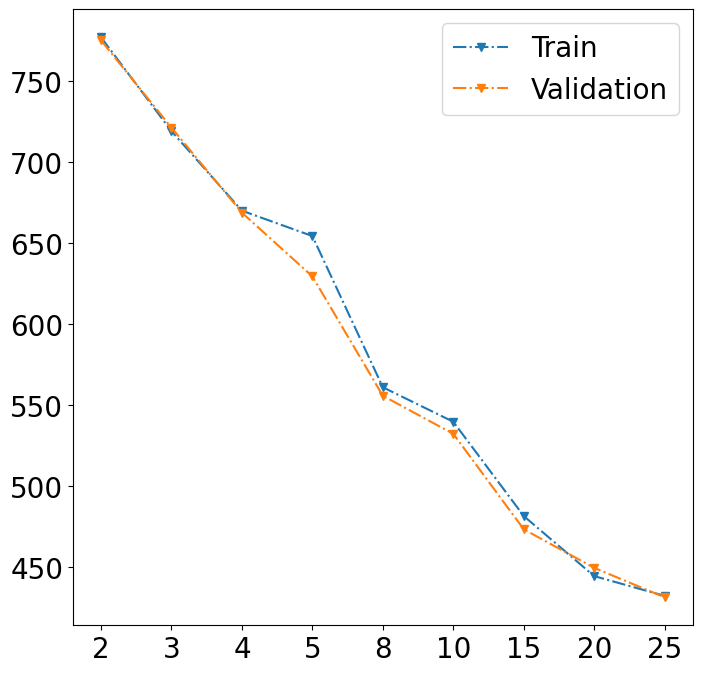

In [11]:
# Use validation to get the optimal number of rules
tsc_cv_train_accuracy = []
tsc_cv_val_accuracy = []

kf = KFold(n_splits=number_of_folds)

for number_of_rules in number_of_rules_array:
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        ts_model = TsModel_constant.TsModel_constant(number_of_rules, fuzzification_coefficient=1.2)
        
        start_time = time.time()
        ts_model.fit(x_train[train_index], y_train[train_index])
        time_used = time.time() - start_time

        tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train[train_index]))
        tsc_val_pred = ts_relu_wrapper(ts_model.predict(x_train[test_index]))

        train_rmse = root_mean_squared_error(y_train[train_index], tsc_train_pred)
        val_rmse = root_mean_squared_error(y_train[test_index], tsc_val_pred)

        tsc_cv_train_accuracy.append(train_rmse)
        tsc_cv_val_accuracy.append(val_rmse)


# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_cv_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='Train')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_cv_val_accuracy).reshape(-1, 10), axis=1), '-.v', label='Validation')


plt.legend()
plt.show()

In [11]:

# TS with linear conclusion
tsl_opt_train_accuracy = []
tsl_opt_test_accuracy = []
tsl_r2s = []
tsl_time = []
tsl_model = None

for fold in range(number_of_folds):
    ts_model = TsModel.TsModel(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsl_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsl_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsl_test_pred)

    tsl_opt_train_accuracy.append(train_rmse)
    tsl_opt_test_accuracy.append(test_rmse)
    tsl_r2 = r2_score(y_test, tsl_test_pred)
    tsl_r2s.append(tsl_r2)
    tsl_time.append(time_used)
    tsl_model = ts_model

tsl_train_accuracy_mean = np.round(np.mean(tsl_opt_train_accuracy), 3)
tsl_train_accuracy_std = np.round(np.std(tsl_opt_train_accuracy), 3)
tsl_test_accuracy_mean = np.round(np.mean(tsl_opt_test_accuracy), 3)
tsl_test_accuracy_std = np.round(np.std(tsl_opt_test_accuracy),3)
tsl_r2_mean = np.round(np.mean(tsl_r2s),3)
tsl_r2_std = np.round(np.std(tsl_r2s),3)
tsl_time_mean = np.round(np.mean(tsl_time),3)
tsl_time_std = np.round(np.std(tsl_time),3)

print(f"TS Linear Train RMSE: {tsl_train_accuracy_mean} ± {tsl_train_accuracy_std}")
print(f"TS Linear Test RMSE: {tsl_test_accuracy_mean} ± {tsl_test_accuracy_std}")
print(f"TS Linear R2: {tsl_r2_mean} ± {tsl_r2_std}")
print(f"TS Linear Time: {tsl_time_mean} ± {tsl_time_std}")

FCM training RMSE: 256.80844933419337
FCM training RMSE: 255.8097566716159
FCM training RMSE: 254.7816204630895
FCM training RMSE: 261.45942300319814
FCM training RMSE: 260.44946066999165
FCM training RMSE: 254.28055539201893
FCM training RMSE: 257.24811445432147
FCM training RMSE: 258.2112469067799
FCM training RMSE: 256.1239436735186
FCM training RMSE: 254.64894294310795
TS Linear Train RMSE: 256.807 ± 2.297
TS Linear Test RMSE: 231.475 ± 2.963
TS Linear R2: 0.985 ± 0.0
TS Linear Time: 0.407 ± 0.099


In [12]:
# TS model
# Constant conclusion
tsc_opt_train_accuracy = []
tsc_opt_test_accuracy = []
tsc_r2s = []
tsc_time = []
tsc_model = None

for fold in range(number_of_folds):
    ts_model = TsModel_constant.TsModel_constant(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsc_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsc_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsc_test_pred)

    tsc_opt_train_accuracy.append(train_rmse)
    tsc_opt_test_accuracy.append(test_rmse)
    tsc_r2 = r2_score(y_test, tsc_test_pred)
    tsc_r2s.append(tsc_r2)
    tsc_time.append(time_used)
    tsc_model = ts_model

tsc_train_accuracy_mean = np.round(np.mean(tsc_opt_train_accuracy), 3)
tsc_train_accuracy_std = np.round(np.std(tsc_opt_train_accuracy), 3)
tsc_test_accuracy_mean = np.round(np.mean(tsc_opt_test_accuracy), 3)
tsc_test_accuracy_std = np.round(np.std(tsc_opt_test_accuracy),3)
tsc_r2_mean = np.round(np.mean(tsc_r2s),3)
tsc_r2_std = np.round(np.std(tsc_r2s),3)
tsc_time_mean = np.round(np.mean(tsc_time),3)
tsc_time_std = np.round(np.std(tsc_time),3)

print(f"TS Constant Train RMSE: {tsc_train_accuracy_mean} ± {tsc_train_accuracy_std}")
print(f"TS Constant Test RMSE: {tsc_test_accuracy_mean} ± {tsc_test_accuracy_std}")
print(f"TS Constant R2: {tsc_r2_mean} ± {tsc_r2_std}")
print(f"TS Constant Time: {tsc_time_mean} ± {tsc_time_std}")

(1804, 150)
[[5.93251416e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.17132161e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.73313475e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.22495412e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.23308755e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.00013581e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[5.93251416e-08 4.39703299e-06 4.80432736e-07 ... 8.69125926e-07
  6.56772616e-08 1.36591123e-07]
 [1.17132161e-08 7.40813503e-16 6.54117267e-16 ... 2.35723030e-17
  3.02061984e-16 5.30681598e-18]
 [1.73313475e-08 3.85368988e-04 5.84238084e-09 ... 2.36982509e-07
  1.90519359e-05 8.71071544e-08]
 ...
 [1.22495412e-05 1.45069233e-04 7.06740411e-04 ... 9.71108320e-06
  8.80555

In [18]:
x_train.shape

(1804, 5)

In [19]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []
gpr_model = None

for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    indices = np.random.choice(x_train.shape[0], 1800, replace=False)      

    start_time = time.time()
    gpr_model.fit(x_train[indices,:], y_train[indices,:])
    time_used = time.time() - start_time

    train_means = gpr_model.predict(x_train)
    test_means = gpr_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)

gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

GP Train RMSE: 60.714 ± 63.253
GP Test RMSE: 1413.805 ± 938.408
GP R2: 0.178 ± 0.753
GP Time: 17.693 ± 10.758


In [20]:
# GPR from TS linear
gp_tsl_train_accuracy = []
gp_tsl_test_accuracy = []
tsl_train_accuracy = []
tsl_test_accuracy = []
gp_tsl_r2s = []
gp_tsl_time = []
gpr_tsl_model = None

# From ts linear
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
        gpr_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsl_model = get_tsl_model(x_train, y_train, number_of_rules)

        start_time = time.time()
        gpr_tsl_model.fit(tsl_model.cen, tsl_model.predict(tsl_model.cen + 1e-8))
        time_used = time.time() - start_time

        gp_train_means = gpr_tsl_model.predict(x_train)
        gp_test_means = gpr_tsl_model.predict(x_test)

        tsl_train_means = tsl_model.predict(x_train)
        tsl_test_means = tsl_model.predict(x_test)

        gp_train_rmse = root_mean_squared_error(y_train, gp_train_means)
        gp_test_rmse = root_mean_squared_error(y_test, gp_test_means)

        gp_tsl_train_accuracy.append(gp_train_rmse)
        gp_tsl_test_accuracy.append(gp_test_rmse)
        tsl_train_accuracy.append(root_mean_squared_error(y_train, tsl_train_means))
        tsl_test_accuracy.append(root_mean_squared_error(y_test, tsl_test_means))
        gp_r2 = r2_score(y_test, gp_test_means)
        gp_tsl_r2s.append(gp_r2)
        gp_tsl_time.append(time_used)

for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_tsl_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_tsl_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_tsl_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_tsl_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_tsl_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_tsl_time[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


FCM training RMSE: 297.57000908541835
FCM training RMSE: 297.5700099720471
FCM training RMSE: 297.57000875859524
FCM training RMSE: 297.5700090241597
FCM training RMSE: 297.57000912023744
FCM training RMSE: 297.5700091395447
FCM training RMSE: 297.5700090204564
FCM training RMSE: 297.57000962636477
FCM training RMSE: 297.57000902962676
FCM training RMSE: 297.5700093412654


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 292.5962182644308
FCM training RMSE: 292.59621549270827
FCM training RMSE: 292.5962159328688
FCM training RMSE: 292.5962153203986
FCM training RMSE: 292.5962155494522
FCM training RMSE: 292.59621516869896
FCM training RMSE: 292.5962148968202
FCM training RMSE: 292.5962186757585


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 292.5962154158255
FCM training RMSE: 292.59621596692784
FCM training RMSE: 293.8922789966236
FCM training RMSE: 283.7120025387829
FCM training RMSE: 283.71200258518667


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 283.71204113182665
FCM training RMSE: 283.71203888618743
FCM training RMSE: 283.7120017076725


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 283.7120035079766
FCM training RMSE: 292.6457099027329
FCM training RMSE: 283.71200153428794
FCM training RMSE: 293.8922792927052


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 280.89466405745117
FCM training RMSE: 292.7558384082172
FCM training RMSE: 283.79018377184076


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 283.7901846281313
FCM training RMSE: 292.75583892849073
FCM training RMSE: 280.8946635232963
FCM training RMSE: 293.10891178386004


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

FCM training RMSE: 292.7558416862359
FCM training RMSE: 291.3669115860343
FCM training RMSE: 280.8946643933431


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.1072134958829
FCM training RMSE: 277.10721345776443


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 281.7010566695916
FCM training RMSE: 277.1072133781676


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 281.7010644609177
FCM training RMSE: 277.1072131669427


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.1072184598455
FCM training RMSE: 277.1072134129197


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.107223229634
FCM training RMSE: 282.8866497779695


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 273.8058636326694
FCM training RMSE: 270.47774213761863


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 270.47772495836
FCM training RMSE: 270.4777411073308


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 274.6624287464688
FCM training RMSE: 274.6624155203267


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 273.8058627900682
FCM training RMSE: 275.0658170658479


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 275.15937434735145
FCM training RMSE: 273.80586381463877


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 267.68956549713954


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 269.0897150599649
FCM training RMSE: 266.690216539917


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 268.12166035446967
FCM training RMSE: 265.61485697205296
FCM training RMSE: 266.7879074233664


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 269.28022098374197


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 265.60271084089186
FCM training RMSE: 267.74207764092324


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 268.0679076592031


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.3754402989405


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 266.25254364028086


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 260.633743805582


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 263.57411772639574


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.7635698437696


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 263.10711039686754


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 266.40376734790624


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 261.8022598436724


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.38128380031196


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 258.3505456615628


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 255.91789216451164


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.02106564246526


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 253.68435853847515


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 258.7828608696953


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 252.7042254487651


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 254.51678490415333


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 261.6859860328569


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 256.2798761014226


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.69680569622676


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 253.66984751885437
Number of rules: 2
GP Train RMSE: 2003.916 ± 405.859
GP Test RMSE: 1951.123 ± 396.8
GP R2: -0.131 ± 0.442
GP Time: 0.014 ± 0.009
Number of rules: 3
GP Train RMSE: 1965.148 ± 444.338
GP Test RMSE: 1915.2 ± 432.769
GP R2: -0.1 ± 0.473
GP Time: 0.015 ± 0.005
Number of rules: 4
GP Train RMSE: 1366.014 ± 684.162
GP Test RMSE: 1326.268 ± 669.735
GP R2: 0.37 ± 0.618
GP Time: 0.019 ± 0.01
Number of rules: 5
GP Train RMSE: 2001.304 ± 639.476
GP Test RMSE: 1948.045 ± 626.536
GP R2: -0.195 ± 0.586
GP Time: 0.01 ± 0.011
Number of rules: 8
GP Train RMSE: 1503.379 ± 907.71
GP Test RMSE: 1466.392 ± 882.793
GP R2: 0.164 ± 0.738
GP Time: 0.014 ± 0.005
Number of rules: 10
GP Train RMSE: 692.75 ± 572.764
GP Test RMSE: 673.209 ± 558.584
GP R2: 0.782 ± 0.452
GP Time: 0.016 ± 0.009
Number of rules: 15
GP Train RMSE: 633.326 ± 592.528
GP Test RMSE: 614.429 ± 578.275
GP R2: 0.797 ± 0.457
GP Time: 0.025 ± 0.008
Number of rules: 20
GP Train RMSE: 395.132 ± 15.296
GP Test RM

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [21]:
# GPR model
gp_tsc_train_accuracy = []
gp_tsc_test_accuracy = []
tsc_train_accuracy = []
tsc_test_accuracy = []
gp_tsc_r2s = []
gp_tsc_time = []
gpr_tsc_model = None

# From ts constant
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
        gpr_tsc_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsc_model = get_tsc_model(x_train, y_train, number_of_rules)
        start_time = time.time()
        gpr_tsc_model.fit(tsc_model.cen, tsc_model.predict(tsc_model.cen + 1e-8))
        time_used = time.time() - start_time

        train_means = gpr_tsc_model.predict(x_train)
        test_means = gpr_tsc_model.predict(x_test)
        tsc_train_means = tsc_model.predict(x_train)
        tsc_test_means = tsc_model.predict(x_test)

        train_rmse = root_mean_squared_error(y_train, train_means)
        test_rmse = root_mean_squared_error(y_test, test_means)

        gp_tsc_train_accuracy.append(train_rmse)
        gp_tsc_test_accuracy.append(test_rmse)
        tsc_train_accuracy.append(root_mean_squared_error(y_train, tsc_train_means))
        tsc_test_accuracy.append(root_mean_squared_error(y_test, tsc_test_means))
        gp_r2 = r2_score(y_test, test_means)
        gp_tsc_r2s.append(gp_r2)
        gp_tsc_time.append(time_used)


for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_tsc_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_tsc_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_tsc_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_tsc_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_tsc_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_tsc_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_tsc_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_tsc_time[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


(1804, 12)
[[3.04787962e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.47929485e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99632823e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95446989e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99628440e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99719563e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 2)
[[3.04787962e-01 6.95212038e-01]
 [7.47929485e-04 9.99252071e-01]
 [9.99632823e-01 3.67177423e-04]
 ...
 [1.95446989e-02 9.80455301e-01]
 [9.99628440e-01 3.71559705e-04]
 [9.99719563e-01 2.80436989e-04]]
FCM training RMSE: 777.0131049676936
(1804, 12)
[[3.04787936e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.47929454e-04 0.00000000e

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(1804, 12)
[[3.04787884e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.47929392e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99632822e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.95446854e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99628440e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99719563e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 2)
[[3.04787884e-01 6.95212116e-01]
 [7.47929392e-04 9.99252071e-01]
 [9.99632822e-01 3.67177560e-04]
 ...
 [1.95446854e-02 9.80455315e-01]
 [9.99628440e-01 3.71559700e-04]
 [9.99719563e-01 2.80436999e-04]]
FCM training RMSE: 777.013093735462


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 18)
[[1.01842563e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.78192263e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.96217386e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99287972e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.94452753e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.29443889e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 3)
[[1.01842563e-01 3.50333682e-01 5.47823755e-01]
 [4.78192263e-04 2.50005635e-05 9.99496807e-01]
 [4.96217386e-04 9.99355550e-01 1.48232808e-04]
 ...
 [9.99287972e-01 4.14173693e-04 2.97854454e-04]
 [1.94452753e-04 9.99627386e-01 1.78161167e-04]
 [6.29443889e-04 9.99257695e-01 1.12861278e-04]]
FCM training RMSE: 713.1130071134976
(1804, 18)
[[3.50333628e-01 0.00000000e+00 0.000

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(1804, 18)
[[1.01842565e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.78192266e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.96217412e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.99287972e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.94452754e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.29443900e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 3)
[[1.01842565e-01 3.50333674e-01 5.47823761e-01]
 [4.78192266e-04 2.50005630e-05 9.99496807e-01]
 [4.96217412e-04 9.99355550e-01 1.48232813e-04]
 ...
 [9.99287972e-01 4.14173645e-04 2.97854434e-04]
 [1.94452754e-04 9.99627386e-01 1.78161166e-04]
 [6.29443900e-04 9.99257695e-01 1.12861278e-04]]
FCM training RMSE: 713.1130065246641
(1804, 18)
[[3.50333847e-01 0.00000000e+00 0.000

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 24)
[[2.09378386e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.18314332e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.97677070e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.44963142e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99289497e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.98316811e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 4)
[[2.09378386e-01 4.29300031e-01 1.45097646e-02 3.46811818e-01]
 [2.18314332e-05 1.05178194e-04 1.51032669e-03 9.98362664e-01]
 [9.97677070e-01 1.42945241e-04 2.03115114e-03 1.48833935e-04]
 ...
 [1.44963142e-04 5.80094184e-03 9.93937749e-01 1.16346090e-04]
 [9.99289497e-01 4.65272761e-04 8.59984982e-05 1.59232020e-04]
 [9.98316811e-01 2.57579349e-04 1.32500003e-03 1.00609861e-

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(1804, 24)
[[1.14376288e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.36161452e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.76831321e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.35920236e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.45969986e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.83601555e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 4)
[[1.14376288e-02 6.34881455e-02 8.35875579e-03 9.16715470e-01]
 [4.36161452e-04 9.99071962e-01 7.27429392e-06 4.84602516e-04]
 [2.76831321e-04 1.00583423e-04 1.27966157e-01 8.71656428e-01]
 ...
 [5.35920236e-01 4.51938453e-04 9.75240249e-05 4.63530302e-01]
 [2.45969986e-04 2.44487398e-04 8.88793628e-01 1.10715914e-01]
 [2.83601555e-04 6.16889018e-05 9.44459143e-01 5.51955668e-

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 24)
[[8.35874855e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.27429323e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.27966270e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.75240319e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.88793517e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.44459168e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 4)
[[8.35874855e-03 6.34881082e-02 9.16715521e-01 1.14376218e-02]
 [7.27429323e-06 9.99071962e-01 4.84602304e-04 4.36161434e-04]
 [1.27966270e-01 1.00583488e-04 8.71656315e-01 2.76831500e-04]
 ...
 [9.75240319e-05 4.51938551e-04 4.63530158e-01 5.35920380e-01]
 [8.88793517e-01 2.44487491e-04 1.10716026e-01 2.45970074e-04]
 [9.44459168e-01 6.16888842e-05 5.51955418e-02 2.83601475e-

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(1804, 24)
[[8.35898139e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.27431538e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.27962655e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.75238039e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.88797110e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.44458360e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 4)
[[8.35898139e-03 9.16713868e-01 6.34893054e-02 1.14378453e-02]
 [7.27431538e-06 4.84609124e-04 9.99071955e-01 4.36162025e-04]
 [1.27962655e-01 8.71659938e-01 1.00581400e-04 2.76825733e-04]
 ...
 [9.75238039e-05 4.63534785e-01 4.51935397e-04 5.35915756e-01]
 [8.88797110e-01 1.10712438e-01 2.44484509e-04 2.45967218e-04]
 [9.44458360e-01 5.51963466e-02 6.16894522e-05 2.83604073e-

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 30)
[[2.35373342e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.32709360e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.87765451e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.25766593e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.14237980e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.40068723e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 5)
[[2.35373342e-01 5.39758616e-03 7.53045734e-01 2.98737263e-03
  3.19596449e-03]
 [2.32709360e-06 1.14901244e-07 5.46593017e-08 1.88819948e-09
  9.99997501e-01]
 [6.87765451e-05 5.28859890e-04 6.39578841e-01 3.59315983e-01
  5.07539613e-04]
 ...
 [2.25766593e-04 7.82225171e-01 2.16617544e-01 1.18705689e-04
  8.12812413e-04]
 [6.14237980e-04 3.04412465e-04 3.80772176e-01 6.18174

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 30)
[[1.63025591e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22126689e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.35084884e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.46728044e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.12703240e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.82675891e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 5)
[[1.63025591e-03 9.03710630e-01 4.75097621e-02 4.16118605e-02
  5.53749153e-03]
 [1.22126689e-03 3.90451289e-04 9.98285137e-01 9.65965143e-05
  6.54845593e-06]
 [8.35084884e-04 8.75051327e-01 9.96917264e-05 8.46709360e-05
  1.23929225e-01]
 ...
 [8.46728044e-01 1.36792218e-01 4.26706185e-04 1.59664309e-02
  8.66008259e-05]
 [1.12703240e-04 2.38082771e-01 2.62280778e-04 6.06939

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 30)
[[4.16118129e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.65965036e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.46710227e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.59664262e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.06939351e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.16208613e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 5)
[[4.16118129e-02 1.63025440e-03 9.03710734e-01 5.53748328e-03
  4.75097151e-02]
 [9.65965036e-05 1.22126685e-03 3.90451012e-04 6.54845512e-06
  9.98285137e-01]
 [8.46710227e-05 8.35085925e-04 8.75051128e-01 1.23929423e-01
  9.96918424e-05]
 ...
 [1.59664262e-02 8.46728162e-01 1.36792105e-01 8.66007984e-05
  4.26706144e-04]
 [6.06939351e-04 1.12703291e-04 2.38083152e-01 7.60934

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\

(1804, 48)
[[5.86935538e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.87713139e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.90439530e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.86291990e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.50707541e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.03796694e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 8)
[[5.86935538e-02 2.21355188e-01 6.48439204e-01 ... 1.16327672e-03
  3.72312909e-02 8.21314792e-04]
 [2.87713139e-09 3.42629279e-11 5.34220320e-09 ... 3.73351002e-09
  3.49514917e-06 2.72145583e-11]
 [8.90439530e-01 3.63431797e-04 1.14515641e-06 ... 3.07386760e-05
  4.83464373e-06 1.09144082e-01]
 ...
 [5.86291990e-01 2.09143945e-04 7.72750430e-05 ... 3.98339115e-01
  3.7412716

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 48)
[[1.79746172e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.28908660e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.19002611e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.05889003e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.96294954e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.31025223e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 8)
[[1.79746172e-03 2.05978388e-01 3.84349232e-02 ... 5.50201720e-02
  1.24828203e-03 5.36285575e-01]
 [1.28908660e-07 9.01502686e-10 1.03655353e-08 ... 1.12028229e-08
  9.35905525e-10 1.01863462e-06]
 [9.19002611e-05 9.38191519e-04 1.02262695e-05 ... 5.17394043e-03
  4.32057356e-01 6.42933537e-06]
 ...
 [3.05889003e-01 1.22602459e-04 8.97584569e-03 ... 6.37494755e-01
  6.4917537

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 48)
[[1.24828205e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.35905542e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.32057517e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.49174918e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.56282389e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.96588648e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 8)
[[1.24828205e-03 1.79746159e-03 5.34031967e-03 ... 2.05978374e-01
  1.55894919e-01 5.36285566e-01]
 [9.35905542e-10 1.28908652e-07 9.99998646e-01 ... 9.01502644e-10
  1.82879074e-07 1.01863459e-06]
 [4.32057517e-01 9.19002661e-05 3.04498914e-05 ... 9.38191736e-04
  5.61691343e-01 6.42933650e-06]
 ...
 [6.49174918e-05 3.05888676e-01 3.78760670e-04 ... 1.22602373e-04
  4.6906404

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 48)
[[5.34032467e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99998646e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.04498854e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.78771240e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.90209030e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.71563605e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 8)
[[5.34032467e-03 5.36286172e-01 3.84349402e-02 ... 2.05975030e-01
  5.50210954e-02 1.55896686e-01]
 [9.99998646e-01 1.01863365e-06 1.03655302e-08 ... 9.01496179e-10
  1.12026655e-08 1.82878947e-07]
 [3.04498854e-05 6.42933528e-06 1.02262701e-05 ... 9.38188144e-04
  5.17388393e-03 5.61685236e-01]
 ...
 [3.78771240e-04 1.67676391e-04 8.97609341e-03 ... 1.22604341e-04
  6.3748107

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 48)
[[5.36286144e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.01863369e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.42933530e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.67676172e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.20927982e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.15683981e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 8)
[[5.36286144e-01 1.55896601e-01 3.84349394e-02 ... 1.24828354e-03
  1.79746761e-03 2.05975190e-01]
 [1.01863369e-06 1.82878953e-07 1.03655304e-08 ... 9.35907835e-10
  1.28908679e-07 9.01496489e-10]
 [6.42933530e-06 5.61685533e-01 1.02262701e-05 ... 4.32063386e-01
  9.19006932e-05 9.38188307e-04]
 ...
 [1.67676172e-04 4.69079720e-02 8.97608149e-03 ... 6.49194556e-05
  3.0590024

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 60)
[[4.21122627e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00647418e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99041515e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.22824021e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.26260544e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.60497427e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 10)
[[4.21122627e-05 1.03274021e-03 9.67964156e-05 ... 5.12146522e-05
  9.98517513e-01 2.05526695e-06]
 [1.00647418e-08 6.07269456e-07 5.73239957e-09 ... 2.14937585e-10
  4.70791715e-09 3.73323318e-10]
 [9.99041515e-01 3.03236442e-08 5.25031874e-08 ... 3.46079385e-06
  4.44693087e-06 8.72265990e-04]
 ...
 [1.22824021e-03 5.05800899e-05 2.99879808e-03 ... 1.25184549e-05
  8.380375

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 60)
[[1.31646437e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99998424e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.13229684e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.30707373e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.38181820e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.79125282e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 10)
[[1.31646437e-05 4.11130927e-06 4.76426649e-05 ... 1.02512022e-04
  2.89923356e-06 6.03873364e-05]
 [9.99998424e-01 1.33900080e-07 4.04669686e-10 ... 2.20542515e-07
  1.02990401e-09 1.56070497e-08]
 [1.13229684e-05 3.04255239e-05 2.42990988e-04 ... 8.08749025e-01
  1.86185368e-01 4.44419337e-03]
 ...
 [2.30707373e-04 1.40474759e-01 2.14484655e-05 ... 1.67624323e-02
  3.917482

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 60)
[[1.07154611e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.62505207e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.50596632e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.98869897e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.02174991e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.49632430e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 10)
[[1.07154611e-05 9.11315587e-07 9.99561798e-01 ... 1.18054632e-06
  3.13438749e-04 1.73570732e-05]
 [5.62505207e-08 1.04118326e-09 1.27989598e-08 ... 1.23163427e-07
  1.19262083e-06 4.26301231e-10]
 [2.50596632e-03 1.49624061e-01 2.34590643e-04 ... 1.85296474e-05
  1.77647392e-06 1.72339112e-04]
 ...
 [9.98869897e-01 4.40342456e-07 2.04904138e-05 ... 8.66702369e-04
  1.027229

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 60)
[[4.18028459e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.21526003e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.09416344e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.20484181e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.13337771e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.64889536e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 10)
[[4.18028459e-06 9.98017444e-01 3.16948171e-06 ... 1.08314929e-03
  8.48887065e-05 4.65302762e-05]
 [1.21526003e-07 9.70522891e-09 1.02434394e-09 ... 1.14888014e-06
  1.09054720e-08 3.83228899e-10]
 [3.09416344e-05 4.18194024e-04 2.45406844e-01 ... 2.80158259e-06
  4.37338902e-06 2.96316805e-04]
 ...
 [1.20484181e-02 1.47753563e-04 5.23650387e-06 ... 1.19061498e-05
  6.037038

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 60)
[[3.16948186e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.02434393e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.45406847e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.23650408e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.13768912e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.94266905e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 10)
[[3.16948186e-06 9.98017444e-01 1.17365154e-04 ... 1.08314934e-03
  1.41329248e-05 4.18028479e-06]
 [1.02434393e-09 9.70522879e-09 2.29952686e-07 ... 1.14888014e-06
  9.99998426e-01 1.21526003e-07]
 [2.45406847e-01 4.18194032e-04 7.33604250e-01 ... 2.80158263e-06
  1.43586153e-05 3.09416349e-05]
 ...
 [5.23650408e-06 1.47753568e-04 1.72518050e-03 ... 1.19061503e-05
  2.999240

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[2.22403373e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.07460701e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.10945994e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.00183237e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.85012144e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.00643707e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[2.22403373e-04 3.19070900e-04 3.96974008e-07 ... 1.11580462e-04
  3.60025828e-06 3.38815259e-05]
 [2.07460701e-09 9.38092617e-08 3.25776523e-10 ... 4.74190036e-06
  1.80010559e-08 4.98808156e-06]
 [3.10945994e-06 3.94342191e-08 1.46788085e-03 ... 1.38893486e-07
  1.35805819e-03 1.09089460e-04]
 ...
 [8.00183237e-04 3.16833123e-06 1.52632606e-06 ... 1.50308258e-05
  1.249922

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[6.26668372e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.26211470e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.37388229e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.08736325e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.53575684e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.39721894e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[6.26668372e-06 9.99675542e-01 1.46496984e-04 ... 4.21498816e-07
  5.20380456e-05 4.31634587e-07]
 [3.26211470e-11 3.74324493e-11 6.08372945e-10 ... 3.83750544e-10
  3.00955945e-08 9.99978751e-01]
 [2.37388229e-09 1.78240233e-07 1.02825136e-09 ... 2.05219426e-08
  3.60523441e-09 9.91927918e-09]
 ...
 [1.08736325e-04 5.58691602e-05 1.53260562e-06 ... 3.04558610e-03
  7.236344

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[4.34970901e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.66477451e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.72390817e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.99260988e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.05164927e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.51270289e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[4.34970901e-05 2.30208865e-05 6.49072995e-04 ... 2.48894351e-06
  7.94401521e-01 8.00980057e-05]
 [1.66477451e-10 6.74750554e-08 5.86834754e-09 ... 3.41831164e-10
  1.41170491e-07 5.36049518e-09]
 [8.72390817e-06 6.78159038e-05 1.60071558e-06 ... 2.47292476e-03
  8.99117981e-07 1.46087237e-07]
 ...
 [7.99260988e-08 9.98646269e-01 4.00209760e-04 ... 1.32268976e-07
  9.367345

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[4.93251076e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.95231428e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.65645498e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.42069072e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.81144645e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.65760510e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[4.93251076e-05 1.21858533e-04 1.58911494e-05 ... 3.59425773e-05
  1.04702939e-01 1.48653845e-06]
 [2.95231428e-11 2.66014859e-08 1.55502233e-10 ... 5.25097394e-11
  1.79448306e-11 4.27122626e-10]
 [5.65645498e-08 7.63253681e-05 2.28002774e-04 ... 9.98449296e-01
  1.01408685e-05 6.36465879e-07]
 ...
 [2.42069072e-04 2.15693713e-03 9.75534666e-01 ... 1.64238577e-04
  7.326439

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[1.08952562e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.55608087e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.92090035e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.74946261e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.51458683e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.59737526e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[1.08952562e-01 4.68797193e-07 1.85199771e-04 ... 9.20954682e-07
  2.72103712e-06 6.35109346e-05]
 [1.55608087e-07 3.58937199e-10 9.72578918e-08 ... 5.93804595e-08
  9.99989099e-01 5.34296384e-06]
 [2.92090035e-07 1.03504362e-03 1.51284336e-08 ... 3.59427494e-07
  1.55113586e-07 4.78095066e-08]
 ...
 [6.74946261e-05 9.20367996e-07 1.13551689e-06 ... 2.85697208e-03
  7.185630

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[9.97798034e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.04882817e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.35312866e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.42427529e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.62130666e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.31642143e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[9.97798034e-01 3.70249586e-04 3.00293893e-06 ... 4.03405828e-04
  5.79273063e-05 3.78245621e-05]
 [3.04882817e-11 2.81323415e-08 9.99979807e-01 ... 2.92791040e-11
  1.47856761e-11 1.17780557e-12]
 [5.35312866e-06 6.64863038e-08 1.79965550e-07 ... 6.39344861e-07
  2.50078012e-08 3.19244104e-06]
 ...
 [6.42427529e-05 8.47956812e-06 5.74054819e-06 ... 2.67557320e-03
  3.188195

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 90)
[[1.06388337e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.15006622e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.77271414e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.31320637e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.11875862e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.45854541e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 15)
[[1.06388337e-04 1.34637296e-05 9.97981507e-01 ... 7.35447434e-06
  2.73886899e-05 1.33102665e-06]
 [2.15006622e-08 1.59292996e-10 3.11069397e-11 ... 2.48237304e-10
  2.01863449e-05 2.00383025e-12]
 [9.77271414e-05 2.33198554e-04 7.02505509e-06 ... 3.80261760e-07
  1.66915873e-07 1.08708405e-03]
 ...
 [2.31320637e-03 9.74812893e-01 1.31827145e-04 ... 1.43054872e-02
  2.095168

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[9.50224646e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.79849602e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.10990181e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.22007233e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.14509628e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.58086528e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[9.50224646e-07 1.80424915e-05 7.67894007e-05 ... 2.41473367e-06
  5.13339350e-06 1.67362402e-04]
 [3.79849602e-10 8.54165428e-13 2.87885882e-08 ... 9.99959441e-01
  2.10006132e-10 2.95863529e-08]
 [1.10990181e-06 7.23896572e-06 1.73430136e-04 ... 5.36678643e-07
  6.65378898e-07 1.48026131e-07]
 ...
 [1.22007233e-04 8.49347565e-08 1.58773050e-04 ... 9.00696638e-07
  5.42781

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[3.48044148e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.59725302e-16 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.86564273e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.76299319e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.23084930e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.49356318e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[3.48044148e-07 4.60896128e-08 2.88019092e-08 ... 3.90704739e-06
  6.55425261e-07 1.09941675e-07]
 [4.59725302e-16 1.20326835e-08 9.99999988e-01 ... 2.80925895e-13
  1.43064855e-16 5.26826274e-18]
 [9.86564273e-01 8.47388673e-07 4.14754088e-07 ... 1.93550179e-07
  7.51396577e-08 3.31810971e-06]
 ...
 [3.76299319e-05 9.65292670e-06 2.11430642e-06 ... 5.35367822e-06
  2.09816

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[2.63311042e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.34361103e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.11388266e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.75256951e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.41526086e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.02161756e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[2.63311042e-06 9.97269944e-05 2.39715565e-05 ... 1.63843392e-06
  2.81899982e-07 1.13481483e-05]
 [3.34361103e-10 2.31301552e-11 3.64943582e-08 ... 2.55221109e-11
  3.78130334e-10 2.22266550e-12]
 [1.11388266e-04 2.06066843e-06 1.37998905e-04 ... 7.28193027e-03
  1.27383834e-06 1.39400239e-05]
 ...
 [9.75256951e-01 4.59472311e-04 2.60282224e-04 ... 2.47547327e-04
  2.19864

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[5.65617625e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.57851569e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.42663282e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.88042003e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.16327133e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.06834306e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[5.65617625e-04 7.53043418e-04 2.22110063e-06 ... 5.40784688e-05
  2.16437498e-04 8.50587882e-05]
 [1.57851569e-11 4.00300636e-09 1.94872130e-12 ... 1.00592954e-08
  1.46361911e-10 1.46808886e-11]
 [3.42663282e-07 9.01600354e-08 1.76636400e-03 ... 8.68952317e-04
  1.70670390e-05 6.78448407e-08]
 ...
 [2.88042003e-05 5.38872915e-07 1.43281053e-07 ... 7.38611328e-05
  9.89616

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[9.99987834e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.46458222e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42875192e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.52895642e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.39620542e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.25393944e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[9.99987834e-01 8.24690357e-10 5.04020439e-09 ... 2.98096707e-07
  2.57476832e-08 7.36710856e-09]
 [3.46458222e-11 1.70122216e-12 2.51708632e-10 ... 3.46964102e-11
  1.16712369e-08 4.73193964e-10]
 [1.42875192e-06 7.76386330e-04 3.86302178e-07 ... 1.06978737e-06
  4.41902474e-04 1.99090658e-05]
 ...
 [1.52895642e-05 4.25497306e-07 1.65521207e-03 ... 1.45186673e-03
  2.18029

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[1.38423763e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99993145e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.94421882e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.40074687e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.23401433e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.64662729e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[1.38423763e-05 1.41069003e-05 2.10947764e-05 ... 6.64606650e-06
  6.15666283e-04 5.41095330e-01]
 [9.99993145e-01 2.95484679e-10 1.03138971e-10 ... 3.69230727e-09
  6.77549075e-07 1.72306282e-09]
 [3.94421882e-07 6.64912594e-05 2.37044879e-06 ... 7.26895095e-01
  6.92862849e-08 3.16914639e-06]
 ...
 [6.40074687e-06 2.49474179e-06 2.02665709e-07 ... 5.88592200e-06
  2.09477

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[2.69356047e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.60739090e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.15892214e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.07925173e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.71469434e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.38922293e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[2.69356047e-04 3.21128518e-05 2.19559630e-06 ... 2.59014671e-04
  2.26750496e-06 6.17951773e-02]
 [2.60739090e-11 9.82461064e-11 2.86382527e-12 ... 7.87830746e-11
  5.42231748e-10 1.56205533e-11]
 [2.15892214e-06 9.84320468e-01 3.31040873e-03 ... 4.42524055e-03
  2.51476787e-05 3.17620643e-05]
 ...
 [7.07925173e-04 3.96024141e-05 4.28837347e-07 ... 6.01349558e-02
  1.18800

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[4.21042439e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.85421491e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.05526903e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.94697115e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.49072520e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.24482322e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[4.21042439e-07 9.99952596e-01 3.44524188e-06 ... 2.30682906e-07
  1.27173212e-07 6.77360420e-08]
 [4.85421491e-06 7.85035316e-11 2.71735661e-08 ... 3.35942758e-05
  3.76741636e-10 2.09443020e-10]
 [5.05526903e-07 7.71160034e-06 1.86155693e-07 ... 3.07464815e-07
  5.19982105e-05 6.62514782e-07]
 ...
 [3.94697115e-06 1.36298088e-05 1.22323756e-06 ... 8.48312395e-07
  9.98582

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[1.52413747e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.46269228e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.34148646e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.45804573e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99332210e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.94740087e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[1.52413747e-07 2.88719441e-07 1.26557613e-07 ... 4.48922522e-09
  9.99999184e-01 1.26232757e-08]
 [8.46269228e-10 1.75532727e-08 1.13803836e-09 ... 1.19473778e-08
  1.88775439e-08 4.97458602e-06]
 [2.34148646e-05 2.23333981e-03 1.01526722e-05 ... 2.59701803e-07
  2.82012261e-06 1.77366743e-04]
 ...
 [8.45804573e-09 6.08471597e-07 1.42538814e-07 ... 1.26358272e-06
  1.15134

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 120)
[[5.96938196e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.55295048e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.28732352e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.42199046e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.36551364e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22202642e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 20)
[[5.96938196e-06 2.10216344e-04 1.20260620e-06 ... 7.39214799e-06
  9.70277823e-06 3.92819627e-05]
 [1.55295048e-10 2.10952162e-13 3.62867072e-18 ... 4.85482984e-16
  2.20402843e-16 5.03017345e-17]
 [2.28732352e-07 1.93425894e-05 3.13075109e-06 ... 9.89016577e-01
  8.33504117e-08 2.20174089e-04]
 ...
 [1.42199046e-06 2.79058929e-04 3.88227880e-08 ... 1.30170791e-05
  1.84655

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[8.26106614e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.23610941e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.84070004e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.90121777e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.67516459e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.43367175e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[8.26106614e-08 1.72077190e-06 4.87044116e-04 ... 2.83124279e-07
  1.60201988e-06 7.21575364e-08]
 [6.23610941e-11 3.83473458e-12 1.03362889e-09 ... 4.05818719e-08
  5.35209396e-10 2.81185148e-10]
 [4.84070004e-07 4.64786499e-05 1.44048909e-06 ... 2.09691665e-04
  8.48575933e-08 1.95847412e-05]
 ...
 [6.90121777e-05 4.01675847e-07 6.90689121e-06 ... 9.33395246e-05
  1.28714

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[7.16172973e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.45823333e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.10802180e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.51278156e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.36899651e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.40995152e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[7.16172973e-05 5.94272271e-06 6.14833653e-05 ... 5.21633721e-04
  9.71851026e-01 1.08505135e-07]
 [4.45823333e-08 1.48244971e-11 5.96360317e-10 ... 9.62287883e-12
  5.15660336e-11 1.81041214e-12]
 [1.10802180e-06 3.19154965e-09 2.00941664e-09 ... 6.72272692e-07
  4.51657438e-07 1.14527426e-04]
 ...
 [2.51278156e-06 5.30911178e-08 2.29096937e-09 ... 2.42773265e-07
  9.39932

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[9.65339651e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.21036761e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42113257e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.07660923e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.71522080e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.97321678e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[9.65339651e-01 5.38773261e-07 1.08314276e-06 ... 7.18256552e-05
  3.13405857e-07 3.25980458e-06]
 [4.21036761e-11 2.37539385e-11 5.47938110e-13 ... 5.71435774e-10
  2.89148219e-12 6.47235454e-11]
 [1.42113257e-07 1.16469055e-05 5.49654994e-08 ... 6.08917400e-10
  2.39832524e-05 3.07134352e-09]
 ...
 [1.07660923e-05 1.07756709e-04 5.12204215e-08 ... 2.40597632e-07
  1.96945

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[4.14085616e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.73694407e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.88086596e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.05061803e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.64296322e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.63463628e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[4.14085616e-06 1.10198293e-06 2.93547647e-05 ... 1.30347075e-07
  6.55661737e-07 3.83645570e-06]
 [7.73694407e-11 5.78292113e-13 1.77307920e-11 ... 2.02131031e-12
  2.13644054e-10 3.13350480e-11]
 [9.88086596e-01 3.51762834e-06 2.25087600e-07 ... 3.37748871e-03
  5.34194479e-07 1.14982558e-07]
 ...
 [1.05061803e-05 3.27827933e-08 1.54132423e-05 ... 1.82352091e-07
  2.35792

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[2.58996148e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.24534253e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.38350090e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.36359486e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.74583819e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.39722534e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[2.58996148e-08 2.57167914e-09 5.26425288e-08 ... 2.60713928e-07
  1.10884878e-08 4.97159412e-09]
 [6.24534253e-11 5.20871510e-10 3.64390733e-12 ... 1.39729967e-11
  1.14987301e-12 1.85156351e-10]
 [4.38350090e-08 3.47993722e-06 6.22966775e-07 ... 4.91362348e-08
  3.26756820e-06 9.12638474e-08]
 ...
 [6.36359486e-05 3.58689986e-03 3.07287171e-06 ... 1.35831488e-05
  2.21085

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[3.53611380e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.55909672e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.19641853e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.92283508e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.13169843e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.34776689e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[3.53611380e-07 1.33774449e-08 7.60575345e-07 ... 2.78967943e-06
  6.45649161e-08 7.36058912e-08]
 [3.55909672e-10 1.46700771e-12 1.70067525e-11 ... 3.63768556e-08
  2.98153829e-11 2.33400782e-10]
 [7.19641853e-06 1.79771456e-04 4.98301767e-08 ... 9.94938479e-08
  8.82012139e-01 3.53608087e-07]
 ...
 [9.92283508e-01 3.75229723e-08 3.13160378e-06 ... 5.43191214e-07
  1.02672

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[7.61622431e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.26667985e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.95333344e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.60725008e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.86551680e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.75383275e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[7.61622431e-07 9.99267149e-01 2.28325141e-08 ... 1.60096704e-07
  2.47273138e-08 3.01410751e-08]
 [6.26667985e-11 2.60266474e-11 2.30830640e-10 ... 1.44893725e-11
  4.85230732e-11 5.71890254e-13]
 [1.95333344e-07 1.12156157e-07 3.31378421e-08 ... 3.19061669e-09
  9.96657628e-01 2.03369530e-07]
 ...
 [7.60725008e-03 3.18176770e-06 6.43852794e-04 ... 4.68416219e-06
  5.51457

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[1.12909955e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99999440e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.68897085e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.23650433e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.34131714e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.68943928e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[1.12909955e-10 1.11219273e-09 1.80183381e-07 ... 1.57332371e-09
  2.49300500e-07 7.21474145e-09]
 [9.99999440e-01 1.23697873e-08 1.96996631e-08 ... 1.53743368e-11
  1.07906941e-11 7.30410033e-11]
 [6.68897085e-07 8.22007155e-04 6.09970946e-06 ... 7.49627445e-08
  2.02044924e-05 3.86447533e-06]
 ...
 [4.23650433e-07 2.89866048e-05 4.43433725e-05 ... 1.67804661e-06
  9.00258

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[1.05839434e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.35999769e-15 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.05245195e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.85891577e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00041428e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.55431148e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[1.05839434e-07 6.08080608e-04 1.19862110e-06 ... 3.23755774e-06
  7.54350471e-05 2.33928021e-02]
 [2.35999769e-15 5.97368942e-17 3.54302018e-18 ... 2.07144907e-17
  2.13936476e-13 6.22650652e-15]
 [1.05245195e-06 1.79937038e-05 2.81839434e-06 ... 8.09398489e-06
  3.02150045e-05 8.58719775e-07]
 ...
 [3.85891577e-04 7.80918967e-05 1.49103213e-07 ... 1.27336635e-05
  1.06671

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(1804, 150)
[[1.87872145e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.87342725e-20 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04231732e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.22413002e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.93240444e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99646584e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(1804, 25)
[[1.87872145e-07 3.01998514e-02 6.60201159e-05 ... 1.14383714e-07
  3.28769564e-05 2.90793583e-07]
 [4.87342725e-20 1.92305122e-17 1.12591345e-17 ... 6.48875317e-18
  2.71841483e-19 1.00000000e+00]
 [1.04231732e-02 1.20511695e-06 6.68408875e-08 ... 1.14839622e-06
  4.54608850e-07 6.46972028e-07]
 ...
 [4.22413002e-09 1.18012053e-07 2.13127120e-09 ... 6.91286158e-07
  2.17585

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [22]:
# GPR model from NN
gp_nn_tsl_train_accuracy = []
gp_nn_tsl_test_accuracy = []
gp_nn_tsl_r2s = []
nn_tsl_r2s = []
gp_nn_tsl_time = []
gpr_nn_tsl_model = None

# From NN and ts linear
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
        gpr_nn_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsl_model = get_tsl_model(x_train, y_train, number_of_rules)

        start_time = time.time()
        inputs = tsl_model.cen
        ts_predictions = tsl_model.predict(tsl_model.cen + 1e-8)
        nn_predictions = nn_model.predict(inputs)
        gpr_nn_tsl_model.fit(inputs, nn_predictions)
        time_used = time.time() - start_time

        train_means = gpr_nn_tsl_model.predict(x_train)
        test_means = gpr_nn_tsl_model.predict(x_test)

        train_rmse = root_mean_squared_error(y_train, train_means)
        test_rmse = root_mean_squared_error(y_test, test_means)

        gp_nn_tsl_train_accuracy.append(train_rmse)
        gp_nn_tsl_test_accuracy.append(test_rmse)
        gp_r2 = r2_score(y_test, test_means)
        gp_nn_tsl_r2s.append(gp_r2)
        gp_nn_tsl_time.append(time_used)
        nn_tsl_r2s.append(r2_score(ts_predictions, nn_predictions))

for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_nn_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_nn_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_nn_tsl_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_nn_tsl_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_nn_tsl_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_nn_tsl_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_nn_tsl_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_nn_tsl_time[idx*10:idx*10+10]),3)
    nn_ts_r2_mean = np.round(np.mean(nn_tsl_r2s[idx*10:idx*10+10]),3)
    nn_ts_r2_std = np.round(np.std(nn_tsl_r2s[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")
    print(f"TS NN R2: {nn_ts_r2_mean} ± {nn_ts_r2_std}")


FCM training RMSE: 297.5700095251523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 297.5700086096895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.57001009441365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.5700090198323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.57000888326485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.5700087281965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.57001003186394
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.57000940596333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

FCM training RMSE: 297.57000866972265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 297.5700089762927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.5962186364008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

FCM training RMSE: 292.59621585737614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
FCM training RMSE: 292.59621537160837
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.5962156619437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.5962152159479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.59621484094475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.59621579204315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.5962180584375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
FCM training RMSE: 292.59621521912857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.59621807632357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

FCM training RMSE: 283.7120026755971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
FCM training RMSE: 292.58784771127375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 283.71200180154864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
FCM training RMSE: 292.5878481120613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.5878469093421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

FCM training RMSE: 283.71204117428215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.5878476009115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 283.71200128443644
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 293.89228242458455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 283.7120399702834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 283.7901840991673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 280.89463615373035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 292.7558386970245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 280.89463556843714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.7558385526563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 280.89463593129426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 280.8946636477218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 283.7901834615881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 280.8946357630576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 292.7558383177951
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 277.10721328198287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
FCM training RMSE: 281.0487131113043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.1072131078147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 275.13308663798546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 277.1072231963284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 281.0487126491653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.10722953583934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.1073190533523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 282.1044209607242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 277.10722282791227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
FCM training RMSE: 275.15940897026303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 270.47772335445126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 274.6624145863481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 270.47774010811827
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 273.80586253887566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 270.47774179964716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 274.5759883921549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 273.8058629495937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 275.77467739409565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 275.0658533463399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 268.0136517481879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 268.36085990010355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 265.03941338622144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 266.58987028218235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 266.7879071264651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 268.08034673107795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 269.0076605391809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
FCM training RMSE: 268.48752622829033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 268.08011928758145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
FCM training RMSE: 266.0249134662572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.55503148012343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.9448588694904
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 261.95453265233965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 263.3489181462316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 254.5342338412992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 261.2061978342732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 263.7266570704531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
FCM training RMSE: 263.9526470756212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 266.4208881697688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 262.74173864518815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 257.138619174047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 254.13197568057203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 256.03959078171147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 255.72691085236033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 256.4971392412551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 257.34238761804795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 256.1702919252867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 255.70710660311437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 263.4285727701853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 255.79127093279226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Number of rules: 2
GP Train RMSE: 2411.228 ± 0.0
GP Test RMSE: 2349.289 ± 0.0
GP R2: -0.575 ± 0.0
GP Time: 0.011 ± 0.007
TS NN R2: 0.855 ± 0.0
Number of rules: 3
GP Train RMSE: 2411.228 ± 0.0
GP Test RMSE: 2349.289 ± 0.0
GP R2: -0.575 ± 0.0
GP Time: 0.012 ± 0.006
TS NN R2: 0.911 ± 0.0
Number of rules: 4
GP Train RMSE: 1470.378 ± 768.228
GP Test RMSE: 1427.991 ± 752.29
GP R2: 0.257 ± 0.679
GP Time: 0.019 ± 0.009
TS NN R2: 0.954 ± 0.029
Number of rules: 5
GP Train RMSE: 807.047 ± 65.102
GP Test RMSE: 779.352 ± 65.353
GP R2: 0.825 ± 0.028
GP Time: 0.023 ± 0.008
TS NN R2: 0.952 ± 0.038
Number of rules: 8
GP Train RMSE: 755.274 ± 551.995
GP Test RMSE: 730.663 ± 539.591
GP R2: 0.765 ± 0.446
GP Time: 0.029 ± 0.009
TS NN R2: 0.951 ± 0.021
Number of rules: 10
GP Train RMSE: 1284.061 ± 920.161
GP Test RMSE: 1248.555 ± 898.617
GP R2: 0.325 ± 0.734
GP Time: 0.02 ± 0.01
TS NN R2: 0.965 ± 0.01
Number of rules: 15
GP Train RMS

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


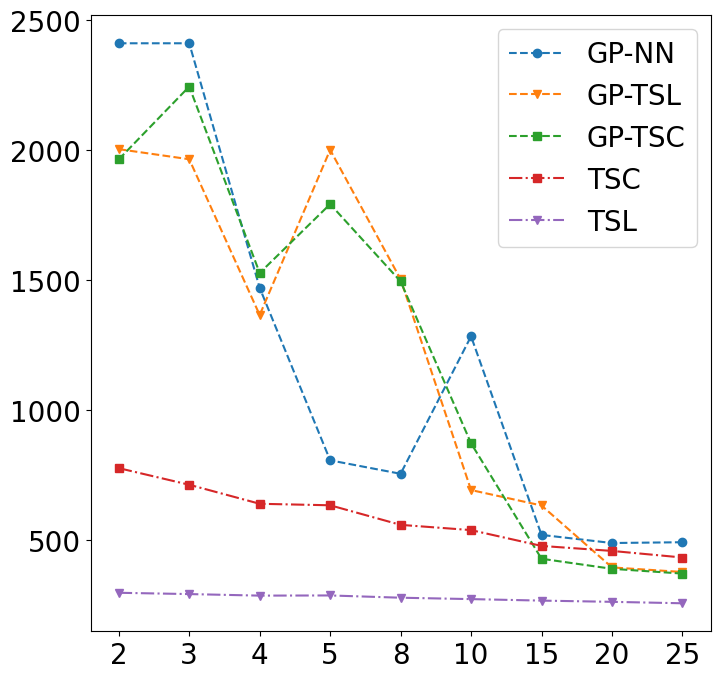

In [23]:
# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_nn_tsl_train_accuracy).reshape(-1, 10), axis=1), '--o', label='GP-NN')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsl_train_accuracy).reshape(-1, 10), axis=1), '--v', label='GP-TSL')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsc_train_accuracy).reshape(-1, 10), axis=1), '--s', label='GP-TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_train_accuracy).reshape(-1, 10), axis=1), '-.s', label='TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='TSL')


plt.legend()
plt.show()

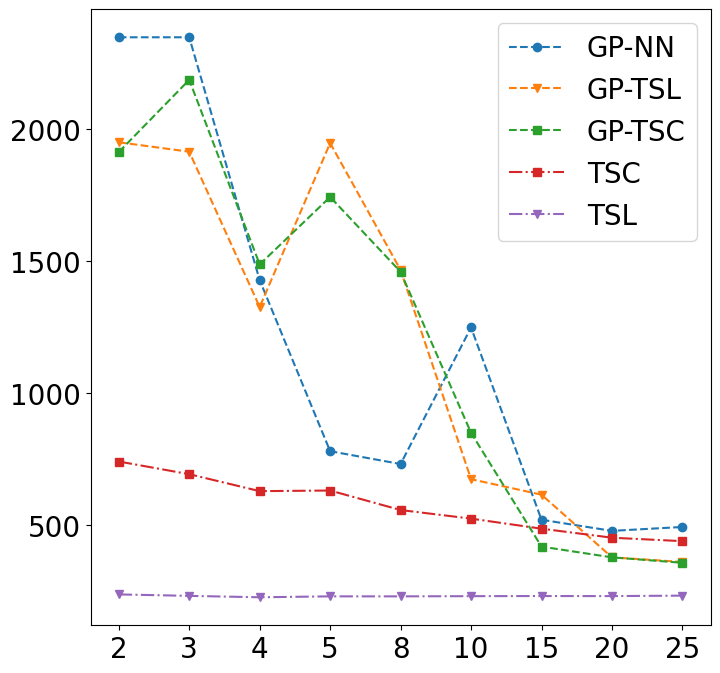

In [24]:
# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_nn_tsl_test_accuracy).reshape(-1, 10), axis=1), '--o', label='GP-NN')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsl_test_accuracy).reshape(-1, 10), axis=1), '--v', label='GP-TSL')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsc_test_accuracy).reshape(-1, 10), axis=1), '--s', label='GP-TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_test_accuracy).reshape(-1, 10), axis=1), '-.s', label='TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_test_accuracy).reshape(-1, 10), axis=1), '-.v', label='TSL')


plt.legend()
plt.show()